<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<font color=3C99D size=5>
    Practical Assignment 5 - NLP - Skip-Gram <br>
<font color=0CBCDF size=4>
   &#x1F335; Amirhossein Akbari  &#x1F335;
</div>

____

<font color=9999FF size=4>
&#x1F388; Full Name : Reza Ghorbani paji
<br>
<font color=9999FF size=4>
&#x1F388; Student Number : 403206565

<font color=0080FF size=3>
This notebook explores word embeddings, compact and dense vector representations of words that capture their textual meaning. This notebook focusing on implementing the Word2Vec algorithm using the Skip-gram architecture and negative sampling.
</font>
<br>

**Note:**
<br>
<font color=66B2FF size=2>In this notebook, you are free to use any function or model from TensorFlow to assist with the implementation. However, PyTorch is not permitted for this exercise. This ensures consistency and alignment with the tools being focused on.</font>
<br>
<font color=red size=3>**Run All Cells Before Submission**</font>: <font color=FF99CC size=2>Before saving and submitting your notebook, please ensure you run all cells from start to finish. This practice guarantees that your notebook is self-consistent and can be evaluated correctly by others.</font>

<font color=#ffb578 size=3>
you are free to modify, add, or remove any cells as you see fit to complete your tasks. Feel free to change any of the provided code or content to better suit your understanding and approach to the problems.

- **Questions**: If you have any questions or require clarifications as you work through the notebook, please do not hesitate to ask. You can post your queries on Quera or reach out via Telegram.
- **Feedback**: We encourage you to seek feedback and engage in discussions to enhance your learning experience and improve your solutions.
</font>

In [ ]:
import io
import math
import gzip
import nltk
import time
import random
import numpy as np
import tensorflow as tf
import gensim.downloader as api
import tensorflow_datasets as tfds
nltk.download('stopwords')
import re
import os

from collections import Counter
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Downloading Dataset
We're going to use text8 dataset. Text8 is first 100,000,000 bytes of plain text from Wikipedia. It's mainly used for testing purposes.

In [ ]:
def load_data():
  text8_zip_file_path = api.load('text8', return_path=True)
  with gzip.open(text8_zip_file_path, 'rb') as file:
    file_content = file.read()
  wiki = file_content.decode()
  return wiki

wiki = load_data()

[==================================================] 100.0% 31.6/31.6MB downloaded


### Preprocessing data

**Stopwords removal** - Begin by removing stopwords from the dataset, as they provide little to no value in learning word embeddings. Ensure your preprocessing pipeline filters out commonly used words such as "the," "and," or "of" that do not contribute to meaningful semantic relationships.

---

**Subsampling words** - In a large corpora, most frequent words can easily occur hundreds of millions of times and such words usually don't bring much information to the table.  It is of essential importance to cut down on their frequencies to mitigate the negative impact it adds. For example, co-occurrences of "English" and "Spanish" benefit much more than co-occurrences of "English" and "the" or "Spanish" and "of". To counter the imbalance between rare and frequent words Mikolov et. al came up with the following heuristic formula for determining probability to drop a particular word:

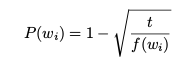

where t is threshold value (heuristically set to 1e-5) and f(w) is frequency of the word.

Implement a subsampling mechanism to handle overly frequent words in the corpus. Use the heuristic formula provided by Mikolov et al. to calculate the probability of dropping a word based on its frequency. This step ensures the corpus maintains a balance between rare and frequent words, improving the quality of word co-occurrence relationships.

---

**Filtering words** - Filter out words that occur only once in the dataset, as they lack sufficient context to be represented effectively. Retain only those words that appear at least five times in the corpus to minimize noise and enhance the overall quality of the embeddings.


In [ ]:
def preprocess_text(text, threshold=1e-5):

    text = re.sub(r'[^\w\s]', ' ', text)

    text = text.lower().strip()
    words = text.split()


    stop_words = set(stopwords.words('english'))
    words = [w for w in words if w not in stop_words]

    word_counts = Counter(words)
    words = [w for w in words if word_counts[w] >= 5]

    word_counts = Counter(words)

    total_count = sum(word_counts.values())

    def subsampling_probability(word):
        f = word_counts[word] / total_count
        p_drop = 1 - (threshold / f)**0.5
        return p_drop

    processed_words = []
    for w in words:
        if random.random() > subsampling_probability(w):
            continue
        processed_words.append(w)

    final_word_counts = Counter(processed_words)

    return processed_words, final_word_counts


It's always a good idea to take a quick look at preprocessed sample before heading further - you might observe few things that if handled can enrich or correct your data. More like a validation step this.

In [ ]:
processed_words, final_word_counts = preprocess_text(wiki)

print(processed_words[1500:1550])


['feminist', 'variant', 'green', 'thought', 'often', 'associated', 'early', 'two', 'zero', 'th', 'century', 'authors', 'goldman', 'de', 'although', 'even', 'early', 'first', 'wave', 'feminist', 'mary', 'held', 'proto', 'anarchist', 'views', 'william', 'often', 'considered', 'noted', 'de', 'though', 'opposed', 'state', 'opposing', 'de', 'explains', 'miss', 'communist', 'wishes', 'wish', 'assert', 'make', 'war', 'upon', 'authority', 'right', 'property', 'true', 'right', 'proper']


### Hyperparameters
Setting a few hyperparamters required for gnerating batches and for deciding the size of word embeddings.



In [ ]:
EMBEDDING_DIM = 128
BUFFER_SIZE = 10000
BATCH_SIZE = 128
EPOCHS = 10
SEED = 42

### Preparing TensorFlow Dataset using Skipgrams

**Generating Skipgrams**

Tokenize your preprocessed textual data and convert the words into their corresponding vectorized tokens. Then, use the `skipgrams` function provided by Keras to generate (word, context) pairs. Ensure the following steps are completed:

- Generate positive samples: (word, word in the same window), with label 1.  
- Generate negative samples: (word, random word from the vocabulary), with label 0.  

Refer to Mikolov et al.'s paper, [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781v3.pdf), for more details on Skipgrams.

---

**Negative Sampling**

For each input word, implement the negative sampling approach to optimize the training process. Transform the problem of predicting context words into independent binary classification tasks. For every (target, context) pair, generate random negative (target, ~context) samples. This step will reduce computational complexity and make training more efficient.


In [ ]:
word_counter = Counter(processed_words)
filtered_words = [w for w in processed_words if word_counter[w] >= 10]

print(f"Original corpus size: {len(processed_words)}")
print(f"Filtered corpus size (>=5 freq): {len(filtered_words)}")


Original corpus size: 6793964
Filtered corpus size (>=5 freq): 6788797


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_words)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print(f"Vocabulary size (filtered): {vocab_size}")

Vocabulary size (filtered): 9940


In [ ]:
sequences = tokenizer.texts_to_sequences([filtered_words])[0]

In [ ]:
def skipgram_generator(
    seq,
    vocab_size,
    chunk_size=50_000,
    window_size=2,
    negative_samples=0.5,
    seed=None
):

    i = 0
    while i < len(seq):
        chunk = seq[i : i + chunk_size]
        i += chunk_size

        sg_pairs, sg_labels = skipgrams(
            chunk,
            vocabulary_size=vocab_size,
            window_size=window_size,
            negative_samples=negative_samples,
            seed=seed
        )

        for (target, context), label in zip(sg_pairs, sg_labels):
            yield (target, context), label


In [ ]:
dataset = tf.data.Dataset.from_generator(
    lambda: skipgram_generator(
        sequences,
        vocab_size=vocab_size,
        chunk_size=50_000,
        window_size=2,
        negative_samples=0.5,
        seed=SEED
    ),
    output_types=((tf.int32, tf.int32), tf.int32),
    output_shapes=(((), ()), ())
)

In [ ]:
dataset = dataset.cache()


In [ ]:
num_samples_to_keep = 1000000 #I got MLE so I train my mode with subset of data
dataset = dataset.take(num_samples_to_keep)

dataset_size = sum(1 for _ in dataset)

train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)


In [ ]:
train_batches = sum(1 for _ in train_dataset)
test_batches = sum(1 for _ in test_dataset)

print(f"(train, test) batches: {train_batches}, {test_batches}")

(train, test) batches: 6250, 1562


### Building the Model

Use the model subclassing method to build your model. While Sequential and Functional APIs are generally more suitable for most use cases, model subclassing allows you to create the model in an object-oriented way. Follow these steps:

1. Define a custom model class by inheriting from `tf.keras.Model`.
2. Implement the `__init__` method to define the layers of your model.
3. Override the `call` method to define the forward pass of your model.
4. Ensure that the model includes embedding layers, a skip-gram architecture, and any other necessary components for training.


In [ ]:
import tensorflow as tf

class SkipGramModel(tf.keras.Model):


    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()


        self.target_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=1,
            name='target_embedding'
        )


        self.context_embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=1,
            name='context_embedding'
        )

    def call(self, inputs):

        target_words, context_words = inputs


        target_emb = self.target_embedding(target_words)
        context_emb = self.context_embedding(context_words)


        dot_product = tf.reduce_sum(target_emb * context_emb, axis=-1)

        return dot_product


In [ ]:
vocab_size = 5000
embedding_dim = 128

skipgram_model = SkipGramModel(vocab_size=vocab_size, embedding_dim=embedding_dim)

dummy_targets = tf.constant([[1], [2], [3]])
dummy_contexts = tf.constant([[2], [3], [1]])

outputs = skipgram_model((dummy_targets, dummy_contexts))
print("Outputs shape:", outputs.shape)
print("Outputs (dot products):", outputs.numpy())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Outputs shape: (3, 1)
Outputs (dot products): [[-0.01332022]
 [ 0.00302748]
 [-0.00533868]]


### Loss function, Metrics and Optimizers

In [ ]:
optimiser = tf.keras.optimizers.Adam(learning_rate=1e-3)

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

train_acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.0)
val_acc_metric = tf.keras.metrics.BinaryAccuracy(threshold=0.0)


### Training the Model

Implement custom training for learning word embeddings to gain finer control over optimization and training tasks. Follow these steps:

1. Define a custom training loop that includes forward propagation, loss computation, and backpropagation.
2. Use the optimizer of your choice to update the model's weights based on the computed gradients.
3. Implement batching for efficient data processing during training.
4. Monitor the loss during each epoch to track the model's performance.
5. Save the trained embeddings for later use once the training is complete.

In [ ]:
from tqdm import tqdm

@tf.function
def train_step(inputs, labels, model, loss_fn, optimizer, train_acc_metric):
    with tf.GradientTape() as tape:
        logits = model(inputs, training=True)
        loss_value = loss_fn(labels, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_acc_metric.update_state(labels, logits)
    return loss_value

@tf.function
def test_step(inputs, labels, model, loss_fn, val_acc_metric):
    logits = model(inputs, training=False)
    val_loss = loss_fn(labels, logits)
    val_acc_metric.update_state(labels, logits)
    return val_loss

def custom_training_loop(epochs=5):
    for epoch in range(epochs):
        epoch_start_time = time.time()
        print(f"Starting epoch: {epoch}")

        train_loss_sum = 0.0
        train_steps = 0
        with tqdm(total=train_batches, desc=f"Epoch {epoch + 1}/{epochs} - Training", unit="batch") as pbar:
            for (x_batch_train, y_batch_train) in train_dataset:
                loss_value = train_step(x_batch_train, y_batch_train, skipgram_model, loss_fn, optimiser, train_acc_metric)
                train_loss_sum += loss_value.numpy()
                train_steps += 1
                pbar.update(1)
        train_acc = train_acc_metric.result().numpy()
        train_loss_avg = train_loss_sum / train_steps
        train_acc_metric.reset_state()

        val_loss_sum = 0.0
        val_steps = 0
        with tqdm(total=test_batches, desc=f"Epoch {epoch + 1}/{epochs} - Validation", unit="batch") as pbar:
            for (x_batch_val, y_batch_val) in test_dataset:
                val_loss = test_step(x_batch_val, y_batch_val, skipgram_model, loss_fn, val_acc_metric)
                val_loss_sum += val_loss.numpy()
                val_steps += 1
                pbar.update(1)

        val_acc = val_acc_metric.result().numpy()
        val_loss_avg = val_loss_sum / val_steps
        val_acc_metric.reset_state()

        epoch_time = time.time() - epoch_start_time
        print(f"Training acc over epoch: {train_acc:.4f}")
        print(f"Cummulative loss: {train_loss_avg:.4f}")
        print(f"Validation acc over epoch: {val_acc:.4f}")
        print(f"Cummulative test loss: {val_loss_avg:.4f}")
        print(f"Time taken: {epoch_time:.2f}s")

custom_training_loop(epochs=5)

Starting epoch: 0


Epoch 1/5 - Validation: 100%|██████████| 1562/1562 [04:19<00:00,  6.02batch/s]


Training acc over epoch: 0.7447
Cummulative loss: 0.4676
Validation acc over epoch: 0.7496
Cummulative test loss: 0.4579
Time taken: 521.52s
Starting epoch: 1


Epoch 2/5 - Validation: 100%|██████████| 1562/1562 [04:12<00:00,  6.20batch/s]


Training acc over epoch: 0.7760
Cummulative loss: 0.4149
Validation acc over epoch: 0.7525
Cummulative test loss: 0.4618
Time taken: 514.04s
Starting epoch: 2


Epoch 3/5 - Validation: 100%|██████████| 1562/1562 [04:08<00:00,  6.28batch/s]


Training acc over epoch: 0.8033
Cummulative loss: 0.3707
Validation acc over epoch: 0.7520
Cummulative test loss: 0.4689
Time taken: 471.95s
Starting epoch: 3


Epoch 4/5 - Validation: 100%|██████████| 1562/1562 [04:06<00:00,  6.33batch/s]


Training acc over epoch: 0.8426
Cummulative loss: 0.3067
Validation acc over epoch: 0.7471
Cummulative test loss: 0.4885
Time taken: 469.88s
Starting epoch: 4


Epoch 5/5 - Validation: 100%|██████████| 1562/1562 [04:13<00:00,  6.15batch/s]

Training acc over epoch: 0.8749
Cummulative loss: 0.2459
Validation acc over epoch: 0.7414
Cummulative test loss: 0.5211
Time taken: 474.62s


In [ ]:
checkpoint_directory = "./checkpoints_skipgram"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

checkpoint = tf.train.Checkpoint(model=skipgram_model, optimizer=optimiser)

manager = tf.train.CheckpointManager(
    checkpoint, directory=checkpoint_directory, max_to_keep=3
)

save_path = manager.save()
print(f"Checkpoint saved at: {save_path}")

target_embedding_weights = skipgram_model.target_embedding.get_weights()[0]
context_embedding_weights = skipgram_model.context_embedding.get_weights()[0]


Checkpoint saved at: ./checkpoints_skipgram/ckpt-1


### Word Embeddings Projector

Follow these steps to visualize the learned word embeddings using TensorFlow's Embedding Projector:

1. Extract the weights of the embedding layer from your trained model.
2. Save the weights into two files:
   - `vecs.tsv`: This file will store the actual vector representations of words.
   - `meta.tsv`: This file will store the associated metadata (e.g., word labels) for visualization.
3. Go to [TensorFlow Embedding Projector](http://projector.tensorflow.org/).
4. Upload the `vecs.tsv` and `meta.tsv` files created in the previous step.
5. Explore the visualizations provided by TensorFlow's Embedding Projector.
<font color=#ffb578>
6.Save the visualization of a word that best demonstrate the quality of your embeddings as an image and store it near the notebook.
7. Compress the folder into a `.zip` file and submit it as part of your work.

</font>


In [ ]:
import os

embedding_layer = skipgram_model.target_embedding
embedding_weights = embedding_layer.get_weights()[0]
print("Embedding matrix shape:", embedding_weights.shape)

output_dir = "./embedding_projector"
os.makedirs(output_dir, exist_ok=True)

vectors_path = os.path.join(output_dir, "vecs.tsv")
metadata_path = os.path.join(output_dir, "meta.tsv")

index_to_word = {idx: word for word, idx in tokenizer.word_index.items()}

with open(vectors_path, 'w', encoding='utf-8') as out_v, \
     open(metadata_path, 'w', encoding='utf-8') as out_m:

    max_id = embedding_weights.shape[0]

    for idx in range(1, max_id + 1):
        if idx not in index_to_word:
            continue
        word = index_to_word[idx]

        embedding_vector = embedding_weights[idx - 1]

        out_m.write(f"{word}\n")

        vector_str = "\t".join(str(x) for x in embedding_vector)
        out_v.write(f"{vector_str}\n")

print("Embedding vectors saved to:", vectors_path)
print("Metadata saved to:", metadata_path)


Embedding matrix shape: (5000, 128)
Embedding vectors saved to: ./embedding_projector/vecs.tsv
Metadata saved to: ./embedding_projector/meta.tsv
